In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
# Set your OpenAI API key here
api_key = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
import base64
import requests
from typing import List, TypedDict, Annotated, Optional
from striprtf.striprtf import rtf_to_text
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [6]:
class AgentState(TypedDict):
    url: Optional[str]
    messages: Annotated[list[AnyMessage], add_messages]
    raw_text: str
    summary:str

In [7]:
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text



def summarize_text(text: str) -> str:
    """
    Generate a short Ukrainian summary for the given text using an LLM model.
    """


    summarization_prompt = PromptTemplate.from_template(
        """Summarize the following text in one short sentence. Summarize to ukrainian.
        
        Text: {text}
        
        Summary:"""
    )

    chain = summarization_prompt | model

    response = chain.invoke({"text": text}).content

    return response


tools = [extract_rtf_text, summarize_text]


llm_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

In [13]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_rtf_text(url: str) -> str:
    Download an RTF document from the given URL and extract plain text from it.

    Args:
        url (str): The URL of the RTF document.

    Returns:
        str: The extracted plain text from the given URL

summarize_text(text: str) -> str:
    Summarizes the given text using the LLM.
    
    Args:
        text (str): The text to summarize.
        
    Returns:
        str: The summary of the text.
"""
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools:\n{textual_description_of_tool} \n 
"""
    sys_msg = SystemMessage(content=prompt)

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    }

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

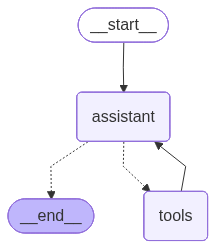

In [15]:
from IPython.display import Image, display

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [HumanMessage(content="Please Extract text from URL in RTF format. http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf")]
messages = react_graph.invoke({"messages": messages})

In [18]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"
messages = [HumanMessage(content=f"Please Extract text from URL in RTF format {url}")]
messages = react_graph.invoke({"messages": messages})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Please Extract text from URL in RTF format http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================== Ai Message ==================================
Tool Calls:
  extract_rtf_text (call_VhYH97rVQv4C7giHe4Q6X1vE)
 Call ID: call_VhYH97rVQv4C7giHe4Q6X1vE
  Args:
    url: http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================= Tool Message =================================
Name: extract_rtf_text


   КИЇВСЬКИЙ ОКРУЖНИЙ АДМІНІСТРАТИВНИЙ СУД |
У Х В А Л А
про залишення позовної заяви без руху
04 грудня 2024 року                           м. Київ                                     № 320/57291/24
Суддя Київського окружного адміністративного суду Жук Р.В., дослідивши матеріали адміністративного позову та додані до нього документи
за позовом   Товариства з обмеженою відповідальністю "Мегого"
до               

In [31]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"
tt = extract_rtf_text(url)

In [36]:
messages = [HumanMessage(content=f"Ось лінка {url} твоя задача видобувати весь текст і сумаризувати його")]
messages = react_graph.invoke({"messages": messages})

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Ось лінка http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf твоя задача видобувати весь текст і сумаризувати його
================================== Ai Message ==================================
Tool Calls:
  extract_rtf_text (call_9iGGrAO5uXgZWNSdYDSZunzJ)
 Call ID: call_9iGGrAO5uXgZWNSdYDSZunzJ
  Args:
    url: http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================= Tool Message =================================
Name: extract_rtf_text


   КИЇВСЬКИЙ ОКРУЖНИЙ АДМІНІСТРАТИВНИЙ СУД |
У Х В А Л А
про залишення позовної заяви без руху
04 грудня 2024 року                           м. Київ                                     № 320/57291/24
Суддя Київського окружного адміністративного суду Жук Р.В., дослідивши матеріали адміністративного позову та додані до нього документи
за позовом   Товариства з обмеженою відповідальністю "Мего

In [ ]:
# "You are a helpful assistant
# You can analyse summarize texts (court cases) and run computations with provided tools:\n{textual_description_of_tool} \n 
# You have access to some url. Currently the loaded url is: {url}")


In [6]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import requests
from striprtf.striprtf import rtf_to_text
from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage


load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [31]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse" 
    }
}

_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


client = get_mcp_client()
mcp_tools = await client.get_tools()

In [32]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    url_list: List[str]

In [4]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

@tool
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text



class MainList(TypedDict):
    urls: List =  Field(..., description="Url rtf links")

@tool
def collect_url(raw_text) -> List:
    """
    Saving in list all url after selecting-quering url from table documents
    """

    # raw_text = state["messages"]
    text_prompt = f"""
    You are a helpful assistant. You can get query result from postgres database. You must analize this inforamtion. If text contains rtf links, please add all this links to list
    If you don't find url's please return empty list
    Input: {raw_text}
    Output: ['url', 'url1', 'url2']
"""
    
    prompt = PromptTemplate(
      input_variables=["text"],
      template=text_prompt
  )   
    model_llm = model.with_structured_output(MainList)

    message = HumanMessage(content=prompt.format(text=text_prompt))
    url_list = model_llm.invoke([message])

    return  {"url_list": url_list}

mcp_tools.append(extract_rtf_text)

mcp_tools.append(collect_url)

In [ ]:
mcp_tools.

[StructuredTool(name='list_schemas', description='List all schemas in the database', args_schema={'properties': {}, 'title': 'list_schemasArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000001E89171EC00>),
 StructuredTool(name='list_objects', description='List objects in a schema', args_schema={'properties': {'schema_name': {'description': 'Schema name', 'title': 'Schema Name', 'type': 'string'}, 'object_type': {'default': 'table', 'description': "Object type: 'table', 'view', 'sequence', or 'extension'", 'title': 'Object Type', 'type': 'string'}}, 'required': ['schema_name'], 'title': 'list_objectsArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000001E8960B3E20>),
 StructuredTool(name='get_object_details', description='Show detailed information about a database object', args_schema={'

In [ ]:
def count_rows(sql_query):
    """
    Changing query and count all rows of query
    """

    new_query = f"""
    SELECT COUNT(*) AS rows_count
    FROM (
    {sql_query}
    ) as t;
    """

    return new_query

In [ ]:
def detect_question(question):
    

In [5]:
print(count_rows("SELECT * FROM documents"))


    SELECT COUNT(*) AS rows_count
    FROM (
    SELECT * FROM documents
    ) as t;

    SELECT * FROM t
    


In [5]:
tt = """привіт ось лінка wap.spaces.rtf"""
rr = collect_url(tt)

TypeError: 'StructuredTool' object is not callable

In [ ]:
rr

{'urls': ['wap.spaces.rtf']}

In [33]:
async def router(state: AgentState):
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools
"""
    sys_msg = SystemMessage(content=prompt)
    response = model.bind_tools(mcp_tools).invoke([sys_msg]+state["messages"])
    return {"messages": response}

In [26]:
from langchain.agents import create_agent

agent = create_agent(
    "gpt-5",
    tools=mcp_tools
)

In [60]:
from typing import Literal

def tools_condition2(
    state: list[AnyMessage] | dict[str, Any],
    messages_key: str = "messages",
) -> Literal["tools", "__end__"]:    
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        for tc in ai_message.tool_calls:
            if tc.get("name") == "execute_sql":
                return "__end__"
        
        return "tools"
    return "__end__"

In [61]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node("router", router)
builder.add_node("tools", ToolNode(mcp_tools))
builder.add_edge(START, "router")
builder.add_conditional_edges(
    "router",
    tools_condition2
)
builder.add_edge("tools", "router")
graph = builder.compile()

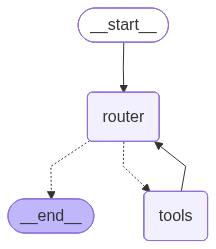

In [62]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [63]:
q = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24?"})

In [64]:
for m in q['messages']:
    m.pretty_print()

================================ Human Message =================================

скільки записів є по справі 136/1512/24?
================================== Ai Message ==================================
Tool Calls:
  list_schemas (call_WaaKHYKsPcIFMe2Z6H1QW1Vj)
 Call ID: call_WaaKHYKsPcIFMe2Z6H1QW1Vj
  Args:
================================= Tool Message =================================
Name: list_schemas

[{'schema_name': 'information_schema', 'schema_owner': 'kaliani', 'schema_type': 'System Information Schema'}, {'schema_name': 'pg_catalog', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'pg_toast', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'public', 'schema_owner': 'pg_database_owner', 'schema_type': 'User Schema'}]
================================== Ai Message ==================================
Tool Calls:
  list_objects (call_LCCyjjt19wcsWLGnD4IAC712)
 Call ID: call_LCCyjjt19wcsWLGnD4IAC712
  Args:
    schema_name: 

In [29]:
q = await agent.ainvoke({"messages": "запусти select from cause_categories"})

In [9]:
# 490/309/24, 136/1512/24, 910/628/20

query = """поверни список url запустивши кверю
select * from documents d
left join judgment_forms j on d.judgment_code = j.judgment_code 
left join cause_categories cc on d.category_code = cc.category_code 
where 1= 1
and d.cause_num = '490/309/24'
"""

q = await graph.ainvoke({"messages": query})

In [56]:
for m in q['messages']:
    m.pretty_print()

================================ Human Message =================================

скільки записів є по справі 136/1512/24?
================================== Ai Message ==================================
Tool Calls:
  list_schemas (call_f61E2VDoBmBEuhmpHSyi2Qzd)
 Call ID: call_f61E2VDoBmBEuhmpHSyi2Qzd
  Args:
================================= Tool Message =================================
Name: list_schemas

[{'schema_name': 'information_schema', 'schema_owner': 'kaliani', 'schema_type': 'System Information Schema'}, {'schema_name': 'pg_catalog', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'pg_toast', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'public', 'schema_owner': 'pg_database_owner', 'schema_type': 'User Schema'}]
================================== Ai Message ==================================
Tool Calls:
  list_objects (call_0aWs9JjlmIPeafrV5nkjZiDw)
 Call ID: call_0aWs9JjlmIPeafrV5nkjZiDw
  Args:
    schema_name: 

In [ ]:
def detect_tool(state: AgentState):
    if 